# Outline of this notebook

This notebook is used to study the relation between corruption and government change in the Mexican procurement market.

In order to study change in the procurement market, we first select contracts that belong to highly volatile buyers and suppliers:

- Buyers with persistence in the first 10th percentile.
- Suppliers with at least 5 contracts disapearing the following year.

The edges of the induced network by these nodes give the set of contracts.

We first select the nodes and the draw the network.

In [1]:
import pandas as pd
import graph_tool.all as gt
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import matplotlib
import scipy.stats

## Contracts

In [3]:
cnts = pd.read_csv('../../data/pre-process/contratos_4.csv')

## Nodes

In [4]:
buyers = np.genfromtxt('../../data/network/volatile_buyers.txt', delimiter='\t', dtype='unicode')

In [5]:
suppliers = np.genfromtxt('../../data/network/volatile_suppliers.txt', delimiter='\t', dtype='unicode')

In [6]:
stable_buyers = np.genfromtxt('../../data/network/stable_buyers.txt', delimiter='\t', dtype='unicode')

## Stable buyers

In [9]:
# Load table
df = cnts[cnts.year==2018]
df = df[['ubuyer', 'usupplier', 'single_bid', 'prop_window', 'daily_price', 's_interaction']]

df = df[(df.ubuyer.isin(stable_buyers))]

In [14]:
cnts[(cnts.year==2018) & (cnts.gvmnt_level=='F')][['ubuyer', 'usupplier', 'single_bid', 'prop_window', 'daily_price', 's_interaction']].mean()

single_bid          0.763269
prop_window        12.625860
daily_price      2039.129967
s_interaction       0.289588
dtype: float64

In [12]:
df.mean()

single_bid          0.888750
prop_window         7.699692
daily_price      1409.600305
s_interaction       0.299882
dtype: float64

## Network

Bipartite public procurement network for the year 2018.

## Federal contracts

### Create edge list

node1, node2, weight, color

In [6]:
# Load table
df = cnts[cnts.year==2018]
df = df[['ubuyer', 'usupplier', 'single_bid', 'prop_window', 'daily_price', 's_interaction']]

df = df[(df.ubuyer.isin(buyers)) & (df.usupplier.isin(suppliers))]

In [7]:
df.shape

(2562, 6)

In [8]:
buyer_size = dict(df.groupby('ubuyer').size())

supplier_size = dict(df.groupby('usupplier').size())

buyer_size.update(supplier_size)

In [9]:
N = df.groupby(['ubuyer', 'usupplier']).size().rename('weight').reset_index()
W = df.groupby(['ubuyer', 'usupplier']).prop_window.mean().rename('PW').reset_index()
S = df.groupby(['ubuyer', 'usupplier']).single_bid.mean().rename('ecolor').reset_index()
D = df.groupby(['ubuyer', 'usupplier']).daily_price.mean().rename('DP').reset_index()
I = df.groupby(['ubuyer', 'usupplier']).s_interaction.mean().rename('CPB').reset_index()

N = pd.merge(N, S, how='left')
N = pd.merge(N, W, how='left')
N = pd.merge(N, D, how='left')
N = pd.merge(N, I, how='left')

In [10]:
N['PW1'] = (N['PW']>=cnts[cnts.year==2018].prop_window.mean()) * 1

N['ecolor'] = (N['ecolor']>=cnts[cnts.year==2018].single_bid.mean()) * 1

N['CPB1'] = (N['CPB']<=cnts[cnts.year==2018].s_interaction.mean()) * 1

In [11]:
g = gt.Graph(directed=False)
# Set property maps for edge attributes
weight = g.new_edge_property('int')
# Edge color
ecolor = g.new_ep('float')
# Daily price
pw = g.new_ep('float')
cpb = g.new_ep('float')

# Create numpy array of edgelist
edgelist = N.drop(['DP', 'PW', 'CPB'], axis=1).values

# Add edges
node_id = g.add_edge_list(edgelist, hashed=True, eprops=[weight, ecolor, pw, cpb])

In [12]:
color = g.new_vp('string')

for v in g.get_vertices():
    if 's' == node_id[v][0]:
        color[v] = 'white'
    else:
        color[v] = 'gray'

In [13]:
pos = gt.sfdp_layout(g)

In [14]:
gt.graph_draw(g, pos=pos,
           vertex_fill_color=color, vertex_size=2, edge_pen_width=weight,
            edge_color=ecolor, ecmap=matplotlib.cm.bwr, output='../../figures/volatile_network.pdf')

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f50ac406df0, at 0x7f50e76feb50>

In [15]:
cnts[cnts.year==2018][['single_bid', 'prop_window', 'daily_price', 's_interaction']].describe()

,single_bid,prop_window,daily_price,s_interaction
count,152929.000000,152929.000000,1.529000e+05,152929.000000
mean,0.713168,12.983574,2.247460e+03,0.302543
std,0.452284,59.189854,9.925166e+04,0.343210
min,0.000000,-457.000000,0.000000e+00,0.002262
25%,0.000000,0.000000,4.400000e+01,0.028571
50%,1.000000,3.000000,2.140000e+02,0.166667
75%,1.000000,12.000000,8.350000e+02,0.500000
max,1.000000,3654.000000,2.571146e+07,1.000000


In [16]:
g

<Graph object, undirected, with 1907 vertices and 1864 edges, at 0x7f50ac406df0>

In [17]:
gt.graph_draw(g, pos=pos,
           vertex_fill_color=color, vertex_size=2, edge_pen_width=weight,
            edge_color=pw, ecmap=matplotlib.cm.bwr_r, output='../../figures/volatile_network_pw.pdf')

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f50ac406df0, at 0x7f50e76feb50>

In [18]:
gt.graph_draw(g, pos=pos,
           vertex_fill_color=color, vertex_size=2, edge_pen_width=weight,
            edge_color=cpb, ecmap=matplotlib.cm.bwr_r, output='../../figures/volatile_network_disp.pdf')

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f50ac406df0, at 0x7f50e76feb50>

## State contracts

In [19]:
sbuyers = pd.read_csv('../../data/network/state_volatile_buyers.csv')
ssuppliers = pd.read_csv('../../data/network/state_volatile_suppliers.csv')

In [57]:
sbuyers.shape

(33, 3)

In [55]:
sbuyers.state.nunique()

21

In [58]:
ssuppliers.shape

(5328, 3)

In [21]:
electoral_years = {
    "AGU": 2016,
    "BCN": 2013,
    "BCS": 2015,
    "CAM": 2015,
    "CHP": 2018,
    "CHH": 2016,
    "CMX": 2018,
    "COA": 2017,
    "COL": 2016,
    "DUR": 2016,
    "GUA": 2018,
    "GRO": 2015,
    "HID": 2016,
    "JAL": 2018,
    "MEX": 2017,
    "MIC": 2015,
    "MOR": 2018,
    "NAY": 2017,
    "NLE": 2015,
    "OAX": 2016,
    "PUE": 2018,
    "QUE": 2015,
    "ROO": 2016,
    "SLP": 2015,
    "SIN": 2017,
    "SON": 2015,
    "TAB": 2018,
    "TAM": 2016,
    "TLA": 2016,
    "VER": 2018,
    "YUC": 2018,
    "ZAC": 2016}

In [34]:
# Load table
dfs = []
for code in sbuyers.state.unique():
    df = cnts[cnts.gvmnt_level=='S']
    df = df[['ubuyer', 'usupplier', 'single_bid', 'daily_price', 'year', 'code_b', 'amount']]
    df = df[(df.code_b==code) & (df.year==electoral_years[code])]
    buyers = sbuyers[sbuyers.state==code].ubuyer.unique()
    suppliers = ssuppliers[ssuppliers.state==code].usupplier.unique()
    dfs.append(df[(df.ubuyer.isin(buyers)) & (df.usupplier.isin(suppliers))])

In [63]:
sbuyers.ubuyer.nunique()

33

In [35]:
state = pd.concat(dfs)

In [64]:
state.ubuyer.nunique()

32

In [65]:
state.usupplier.nunique()

442

In [67]:
state.code_b.nunique()

21

In [70]:
N = state.groupby(['ubuyer', 'usupplier']).size().rename('weight').reset_index()
W = state.groupby(['ubuyer', 'usupplier']).daily_price.mean().rename('amount').reset_index()
S = state.groupby(['ubuyer', 'usupplier']).single_bid.mean().rename('ecolor').reset_index()
N = pd.merge(N, S, how='left')
N = pd.merge(N, W, how='left')

In [71]:
N['amount1'] = (N['amount']>=cnts[cnts.gvmnt_level=='S'].amount.mean()) * 1

N['ecolor1'] = (N['ecolor']>=cnts[cnts.gvmnt_level=='S'].single_bid.mean()) * 1

In [72]:
g = gt.Graph(directed=False)
# Set property maps for edge attributes
weight = g.new_edge_property('int')
# Edge color
ecolor = g.new_ep('float')
# Daily price
dp = g.new_ep('float')

# Create numpy array of edgelist
edgelist = N.drop(['ecolor', 'amount'], axis=1).values

# Add edges
node_id = g.add_edge_list(edgelist, hashed=True, eprops=[weight, dp, ecolor])

In [73]:
color = g.new_vp('string')

for v in g.get_vertices():
    if 's' == node_id[v][0]:
        color[v] = 'white'
    else:
        color[v] = 'gray'

In [74]:
pos = gt.sfdp_layout(g)

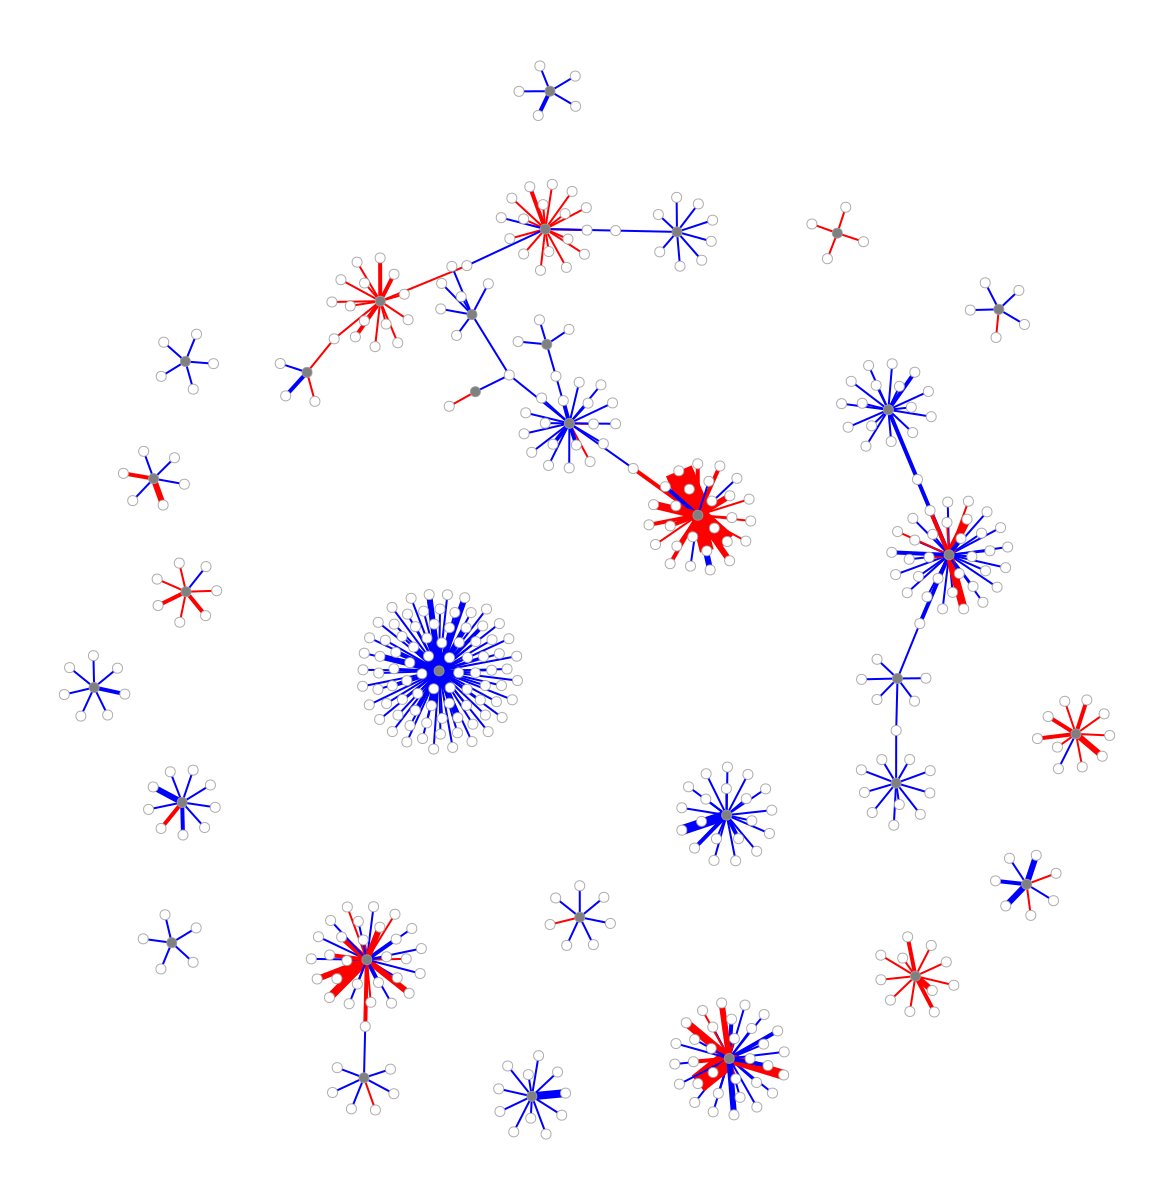

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f4f918e0430, at 0x7f50695c5cd0>

In [75]:
gt.graph_draw(g, pos=pos,
           vertex_fill_color=color, vertex_size=5, edge_pen_width=weight,
            edge_color=ecolor, ecmap=matplotlib.cm.bwr)

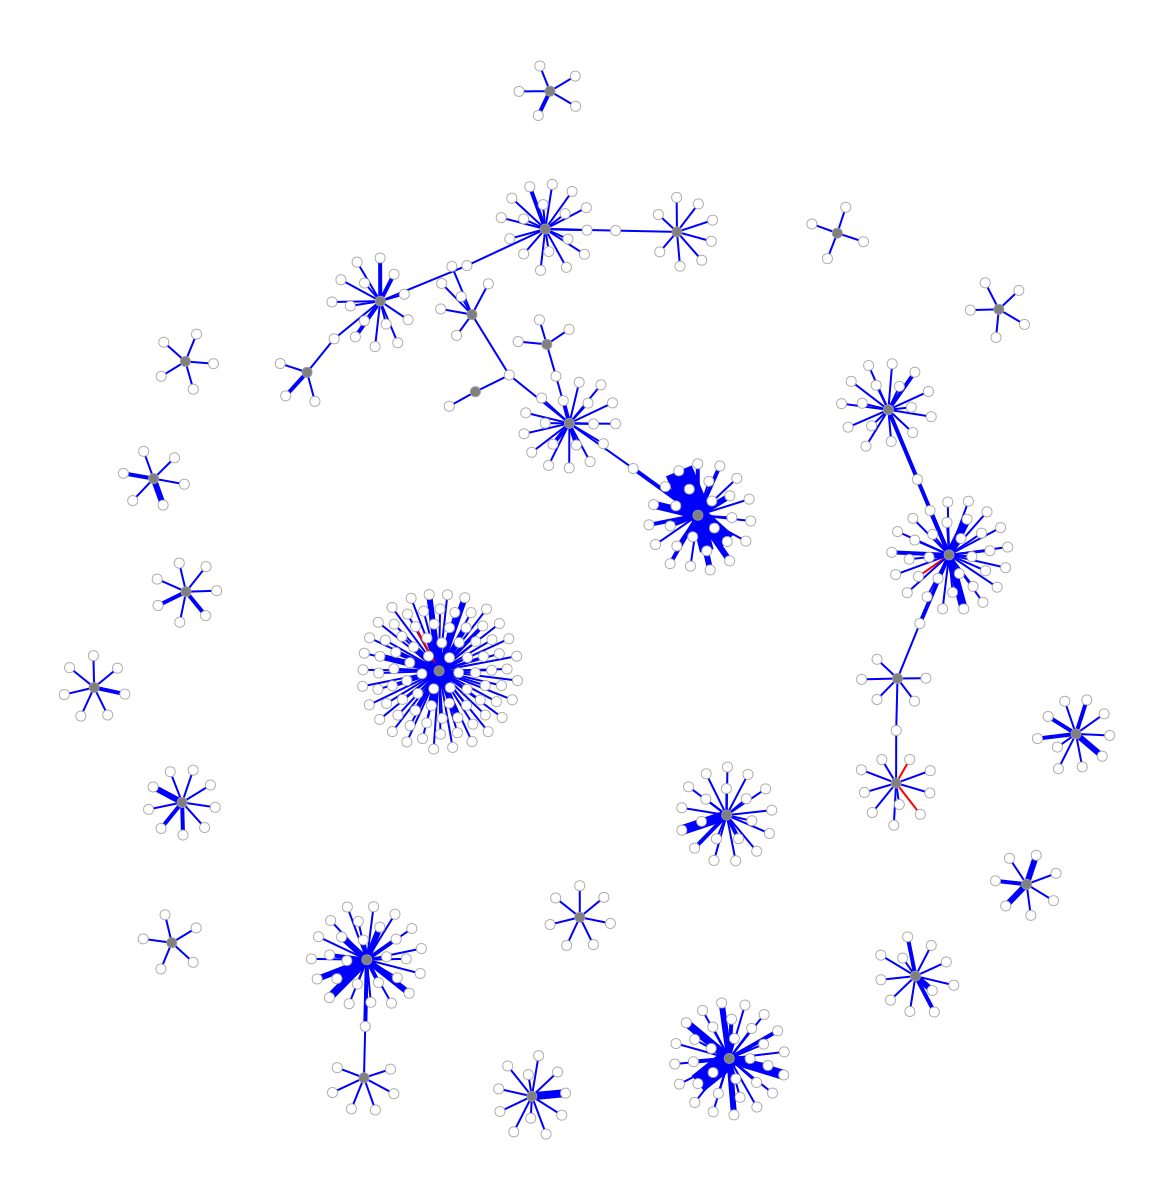

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f4f918e0430, at 0x7f50695c5cd0>

In [76]:
gt.graph_draw(g, pos=pos,
           vertex_fill_color=color, vertex_size=5, edge_pen_width=weight,
            edge_color=dp, ecmap=matplotlib.cm.bwr)

In [46]:
cnts[cnts.gvmnt_level=='S'][['single_bid', 'daily_price', 'amount']].describe()

,single_bid,daily_price,amount
count,116908.000000,1.168780e+05,1.169080e+05
mean,0.288843,5.229638e+03,2.946181e+05
std,0.453227,1.323053e+05,6.532742e+06
min,0.000000,0.000000e+00,0.000000e+00
25%,0.000000,1.760000e+02,1.059800e+04
50%,0.000000,6.930000e+02,4.598450e+04
75%,1.000000,2.117000e+03,1.551505e+05
max,1.000000,2.933071e+07,1.759842e+09


In [84]:
N.amount1.value_counts(normalize=True)

0    0.99117
1    0.00883
Name: amount1, dtype: float64

In [85]:
N.ecolor1.value_counts(normalize=True)

0    0.715232
1    0.284768
Name: ecolor1, dtype: float64

In [45]:
N.describe()

,weight,ecolor,amount,amount1,ecolor1
count,453.000000,453.000000,453.000000,453.000000,453.000000
mean,1.379691,0.270199,9014.433542,0.543046,0.284768
std,1.113765,0.436698,50770.532052,0.498694,0.451803
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,174.000000,0.000000,0.000000
50%,1.000000,0.000000,761.000000,1.000000,0.000000
75%,1.000000,1.000000,1811.000000,1.000000,1.000000
max,14.000000,1.000000,704655.000000,1.000000,1.000000


## Statistical test

Lets get the mean values of each of the variables, namely `single_bid`, `prop_window`, and `s_interaction`.

In [ ]:
# Rest of the network
df_ran = cnts[cnts.year==2018]
df_ran = df_ran[['ubuyer', 'usupplier', 'single_bid', 'prop_window', 's_interaction']]

df_ran = df_ran[~((df_ran.ubuyer.isin(buyers)) & (df_ran.usupplier.isin(suppliers)))]

In [ ]:
np.random.seed(42)
data = []
for i in range(1000):
    ind = np.random.randint(0, df_ran.shape[0], df.shape[0])
    ran = df_ran.iloc[ind]
    ran = ran.groupby(['ubuyer', 'usupplier']).mean()
    ran_sb = ran.single_bid.mean()
    ran_pw = ran.prop_window.mean()
    ran_dis = ran.s_interaction.mean()
    data.append([ran_sb, ran_pw, ran_dis])

In [ ]:
null = pd.DataFrame(data, columns=['single_bid', 'prop_window', 's_interaction'])

In [ ]:
sns.displot(null.single_bid)

In [ ]:
sns.displot(null.prop_window)

In [ ]:
sns.displot(null.s_interaction)

In [ ]:
N.describe()

In [ ]:
## Cross Checking with the internal scipy function
a = null.single_bid
b = N.ecolor

t2, p2 = scipy.stats.ttest_ind(a,b)
print("t = " + str(t2))
print("p = " + str(p2))

In [ ]:
## Cross Checking with the internal scipy function
a = null.prop_window
b = N.PW

t2, p2 = scipy.stats.ttest_ind(a,b)
print("t = " + str(t2))
print("p = " + str(p2))

In [ ]:
## Cross Checking with the internal scipy function
a = null.s_interaction
b = N.CPB

t2, p2 = scipy.stats.ttest_ind(a,b)
print("t = " + str(t2))
print("p = " + str(p2))

## Statistical test

Lets get the mean values of each of the variables, namely `single_bid`, `prop_window`, and `s_interaction`.

In [20]:
df = cnts[(cnts.gvmnt_level=='F') & (cnts.year==2018) & (cnts.ubuyer.isin(stable_buyers))][['ubuyer', 'usupplier', 'single_bid', 'prop_window', 'daily_price', 's_interaction']]

In [26]:
fed = cnts[cnts.gvmnt_level=='F']

In [28]:
fed[fed.year==2018].shape

(135314, 36)

In [21]:
df.ubuyer.nunique()

83

In [22]:
df.shape

(28827, 6)

In [30]:
df.mean()

single_bid          0.888750
prop_window         7.699692
daily_price      1409.600305
s_interaction       0.299882
dtype: float64

In [29]:
# Rest of the network
df_ran = fed[(~fed.isin(stable_buyers))]
df_ran = df_ran[['ubuyer', 'usupplier', 'single_bid', 'prop_window', 's_interaction']]

In [31]:
np.random.seed(42)
data = []
for i in range(1000):
    ind = np.random.randint(0, df_ran.shape[0], df.shape[0])
    ran = df_ran.iloc[ind]
    # ran = ran.groupby(['ubuyer', 'usupplier']).mean()
    ran_sb = ran.single_bid.mean()
    ran_pw = ran.prop_window.mean()
    ran_dis = ran.s_interaction.mean()
    data.append([ran_sb, ran_pw, ran_dis])

In [32]:
null = pd.DataFrame(data, columns=['single_bid', 'prop_window', 's_interaction'])

In [35]:
## Cross Checking with the internal scipy function
a = null.single_bid
b = df.single_bid

t2, p2 = scipy.stats.ttest_ind(a,b)
print("t = " + str(t2))
print("p = " + str(p2))

t = -15.211285341157843
p = 4.669428074879564e-52


In [36]:
## Cross Checking with the internal scipy function
a = null.prop_window
b = df.prop_window

t2, p2 = scipy.stats.ttest_ind(a,b)
print("t = " + str(t2))
print("p = " + str(p2))

t = -1.2532081367419983
p = 0.2101397939131267


In [39]:
## Cross Checking with the internal scipy function
a = null.s_interaction
b = df.s_interaction

t2, p2 = scipy.stats.ttest_ind(a,b)
print("t = " + str(t2))
print("p = " + str(p2))

t = -2.9142887435911313
p = 0.00356764897886579
